Importing All the necessary libraries here:

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
import matplotlib as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics import classification_report, accuracy_score
from gensim.utils import simple_preprocess
from joblib import dump

Load the dataset:

In [7]:
data_frame = pd.read_csv("../main_datasets/sarcasm_data.csv")
data_frame.head()

,Unnamed: 0.1,Unnamed: 0,label,comment,votes,sentiment
0,0,0,0,NC and NH.,-1,0
1,1,1,0,You do know west teams play against west teams...,-1,1
2,2,2,0,"They were underdogs earlier today, but since G...",3,0
3,3,3,0,"This meme isn't funny none of the ""new york ni...",-1,0
4,4,4,0,I could use one of those tools.,-1,1


In [8]:
data_frame = data_frame[["label", "comment", "votes", "sentiment"]]
data_frame.head()


,label,comment,votes,sentiment
0,0,NC and NH.,-1,0
1,0,You do know west teams play against west teams...,-1,1
2,0,"They were underdogs earlier today, but since G...",3,0
3,0,"This meme isn't funny none of the ""new york ni...",-1,0
4,0,I could use one of those tools.,-1,1


Lets perform some data preprocessing:


In [9]:
def preprocess(text):
    return simple_preprocess(text, deacc=True, min_len=2, max_len=15)

data_frame['preprocessed_text'] = data_frame['comment'].apply(preprocess)
data_frame.dropna()
data_frame.head()

,label,comment,votes,sentiment,preprocessed_text
0,0,NC and NH.,-1,0,"[nc, and, nh]"
1,0,You do know west teams play against west teams...,-1,1,"[you, do, know, west, teams, play, against, we..."
2,0,"They were underdogs earlier today, but since G...",3,0,"[they, were, underdogs, earlier, today, but, s..."
3,0,"This meme isn't funny none of the ""new york ni...",-1,0,"[this, meme, isn, funny, none, of, the, new, y..."
4,0,I could use one of those tools.,-1,1,"[could, use, one, of, those, tools]"


In [10]:
embedding_size = 300
word2vec_model = Word2Vec(data_frame['preprocessed_text'], vector_size=embedding_size, window=5, min_count=2, workers=4)
word2vec_model

Lets create the word embeddings:

In [11]:
def text_to_embedding(text):
    words = [word for word in text if word in word2vec_model.wv]
    if words:
        return np.mean(word2vec_model.wv[words], axis=0)
    else:
        return np.zeros(embedding_size)

data_frame['embedding'] = data_frame['preprocessed_text'].apply(text_to_embedding)


In [48]:
embeddings = np.vstack(data_frame["embedding"].apply(lambda x: np.array(x)).values)
embeddings

array([[ 0.03289923,  0.25931451,  0.07404495, ..., -0.06561238,
         0.26164982, -0.02224895],
       [ 0.56608999,  0.2741839 ,  0.33038273, ...,  0.22178158,
         0.95825994, -0.23947692],
       [ 0.46619812,  0.03003519, -0.02921075, ..., -0.22232284,
         0.02572958,  0.00340018],
       ...,
       [ 0.37774956,  0.21838407,  0.45729229, ..., -0.1966497 ,
         0.16736273,  0.3999469 ],
       [ 0.1700002 , -0.0025291 ,  0.11901392, ..., -0.27917141,
        -0.09173427,  0.26709235],
       [ 0.22507229,  0.02109096,  0.29999074, ...,  0.19800124,
         0.29586008,  0.2717829 ]])

Create train and target sets:

In [37]:
embedding_df = pd.DataFrame(data_frame['embedding'].tolist())
expanded_df = pd.concat([data_frame.drop('embedding', axis=1), embedding_df], axis=1)
X = expanded_df.drop('label', axis=1)
y = expanded_df['label']




In [39]:

print(X)
print(y)

                                                   comment  votes  sentiment  \
0                                               NC and NH.     -1          0   
1        You do know west teams play against west teams...     -1          1   
2        They were underdogs earlier today, but since G...      3          0   
3        This meme isn't funny none of the "new york ni...     -1          0   
4                          I could use one of those tools.     -1          1   
...                                                    ...    ...        ...   
1010768  I'm sure that Iran and N. Korea have the techn...      2          0   
1010769                 whatever you do, don't vote green!      1          1   
1010770  Perhaps this is an atheist conspiracy to make ...      1          1   
1010771  The Slavs got their own country - it is called...      1          1   
1010772  values, as in capitalism .. there is good mone...      2          1   

                                       

Lets split the dataset into train and test:

In [40]:
X = X.drop(columns=["comment", "preprocessed_text"])
X.columns = X.columns.astype(str)
X

,votes,sentiment,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,-1,0,0.032899,0.259315,0.074045,-0.240282,0.153468,-0.439202,0.201811,0.236742,...,0.096078,0.067767,0.241012,-0.162217,-0.243622,0.197550,-0.140017,-0.065612,0.261650,-0.022249
1,-1,1,0.566090,0.274184,0.330383,0.090265,-0.112625,-0.592166,0.466998,0.590925,...,-0.260636,-0.315293,0.373087,-0.274836,0.191007,0.114894,0.198667,0.221782,0.958260,-0.239477
2,3,0,0.466198,0.030035,-0.029211,0.181751,-0.132667,-0.557121,-0.024480,0.488845,...,-0.284358,-0.249399,-0.066428,0.298337,-0.381401,-0.183120,-0.398779,-0.222323,0.025730,0.003400
3,-1,0,0.512332,-0.137986,-0.001929,0.389202,0.167922,-0.550504,0.028318,0.607740,...,-0.237013,-0.364918,-0.446469,0.695189,-0.013847,-0.094530,0.141189,-0.117848,0.200279,0.019795
4,-1,1,0.376255,0.318874,0.169532,0.364098,-0.236941,-0.432182,-0.004287,-0.077954,...,-0.090229,-0.618675,-0.221332,-0.001314,-0.382000,0.675321,-0.241337,-0.229513,-0.060435,0.451531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010768,2,0,0.267209,0.396875,0.454103,0.277974,-0.016658,-0.228467,0.052338,0.691045,...,-0.139701,0.089843,0.074870,0.183346,-0.143271,-0.035481,0.033624,-0.082560,0.241960,0.145757
1010769,1,1,0.406560,0.747790,0.064376,0.892850,0.151067,-0.487105,0.217542,1.055288,...,-0.406489,-0.472473,-0.281398,-0.129504,0.493569,0.343159,0.096871,-0.290011,0.032824,0.189393
1010770,1,1,0.377750,0.218384,0.457292,0.350636,0.296861,-0.355829,0.133377,1.206182,...,-0.382304,-0.050233,-0.138623,0.016789,0.172130,-0.351860,0.021824,-0.196650,0.167363,0.399947
1010771,1,1,0.170000,-0.002529,0.119014,0.074239,-0.077937,-0.387367,0.126550,0.723129,...,-0.498656,0.304623,0.062145,0.461133,0.212530,0.131837,-0.130495,-0.279171,-0.091734,0.267092


In [49]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

Move the data onto CUDA:


In [50]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)

PyTorch Version: 2.0.0+cu117
CUDA Version: 11.7


In [51]:
X_train = torch.from_numpy(X_train).float().cuda()
y_train = torch.from_numpy(y_train).float().cuda()
X_val = torch.from_numpy(X_test).float().cuda()
y_val = torch.from_numpy(y_test).float().cuda()


TypeError: expected np.ndarray (got Series)

Lets train the SVM:

In [ ]:
class SVM(torch.nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.zeros(n_features, requires_grad=True))
        self.b = torch.nn.Parameter(torch.zeros(1, requires_grad=True))

    def forward(self, x):
        return torch.dot(self.alpha, x) + self.b

In [ ]:
model = SVM(n_features=X_train.shape[1]).cuda()
model.fit(X_train, y_train)
model

In [5]:
y_pred = model.predict(X_test)

NameError: name 'model' is not defined

In [ ]:
y_pred_proba = model.predict_proba(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.90      0.72     33744
           1       0.66      0.26      0.37     26256

    accuracy                           0.62     60000
   macro avg       0.63      0.58      0.55     60000
weighted avg       0.63      0.62      0.57     60000



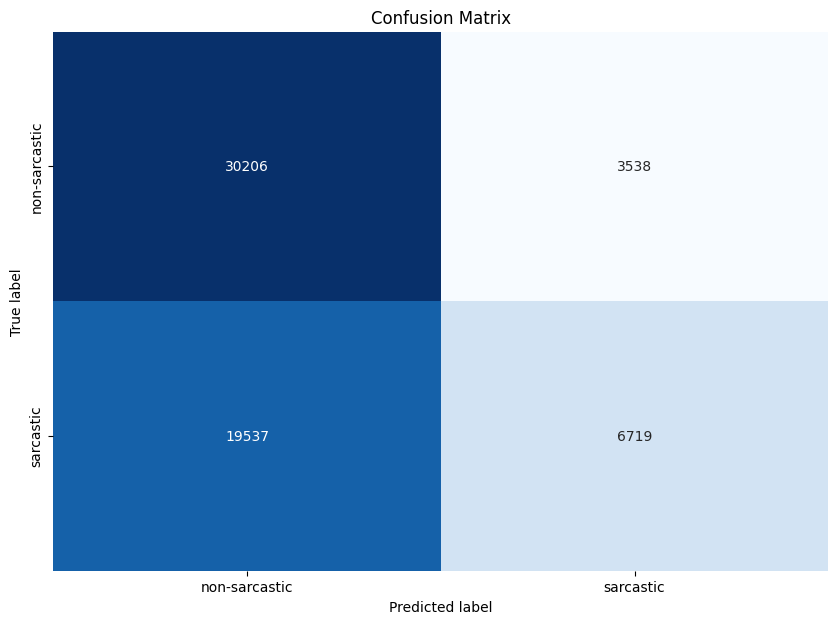

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=cm, cmap='Blues', fmt='d', cbar=False,
                xticklabels=class_names, yticklabels=class_names)

    # Set the axis labels
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Set the title
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()
plot_confusion_matrix(y_test, y_pred, ["non-sarcastic", "sarcastic"])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_auc_curve(y_true, y_pred_proba, title='ROC AUC Curve'):
    # Compute the ROC curve points and AUC score
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Create the ROC curve plot
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    # Display the plot
    plt.show()

plot_roc_auc_curve(y_test, y_pred_proba[:,1])


NameError: name 'y_pred_proba' is not defined

In [ ]:
dump(model, "svm.joblib")